In [1]:
import numpy as np
import h5py
import params
import arrayfire as af
import matplotlib.pyplot as pl
import cks.initialize as initialize
import cks.fdtd as fdtd
af.set_backend("cpu")

% matplotlib inline

In [2]:
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'
pl.rcParams['image.cmap']      = 'jet'
pl.rcParams['savefig.dpi']     = 300

pl.rcParams['xtick.major.size'] = 8
pl.rcParams['xtick.minor.size'] = 4
pl.rcParams['xtick.major.pad']  = 8
pl.rcParams['xtick.minor.pad']  = 8
pl.rcParams['xtick.color']      = 'k'
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'

pl.rcParams['ytick.major.size'] = 8
pl.rcParams['ytick.minor.size'] = 4
pl.rcParams['ytick.major.pad']  = 8
pl.rcParams['ytick.minor.pad']  = 8
pl.rcParams['ytick.color']      = 'k'
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'

In [3]:
config = initialize.set(params)

In [4]:
spread = 0.1

def gauss1D(x):
    return af.exp(-((x)**2 )/(2*spread**2))

In [5]:
X = initialize.calculate_x(config)[:, :, 0, 0]
Y = initialize.calculate_y(config)[:, :, 0, 0]

In [6]:
left_boundary  = config.left_boundary
right_boundary = config.right_boundary
bot_boundary   = config.bot_boundary
top_boundary   = config.top_boundary

length_x = right_boundary - left_boundary
length_y = top_boundary - bot_boundary

N_x = config.N_x
N_y = config.N_y

In [7]:
dx = (length_x/(N_x - 1))
dy = (length_y/(N_y - 1))

dt = (dx/2)

final_time = 1
time       = np.arange(0, final_time, dt)

In [8]:
Ex = af.data.constant(0, X.shape[0], X.shape[1], dtype=af.Dtype.f64)
Ey = af.data.constant(0, X.shape[0], X.shape[1], dtype=af.Dtype.f64)
Ez = af.data.constant(0, X.shape[0], X.shape[1], dtype=af.Dtype.f64)
Bx = af.data.constant(0, X.shape[0], X.shape[1], dtype=af.Dtype.f64)
By = af.data.constant(0, X.shape[0], X.shape[1], dtype=af.Dtype.f64)
Bz = af.data.constant(0, X.shape[0], X.shape[1], dtype=af.Dtype.f64)

In [9]:
Ex[1:-1, 1:-1] = gauss1D((X[1:-1, 1:-1] - 0.5)*(Y[1:-1, 1:-1] - 0.5))
Ey[1:-1, 1:-1] = gauss1D((X[1:-1, 1:-1] - 0.5)*(Y[1:-1, 1:-1] - 0.5))

In [10]:
# pl.contourf(np.array(X[1:-1, 1:-1]), np.array(Y[1:-1, 1:-1]), np.array(Ex[1:-1, 1:-1]), 100)
# pl.title('$E_x(t=0)$')
# pl.xlabel('$x$')
# pl.ylabel('$y$')
# pl.colorbar()

In [11]:
Ex_initial = Ex.copy()
Ey_initial = Ey.copy()
Ez_initial = Ez.copy()
Bx_initial = Bx.copy()
By_initial = By.copy()
Bz_initial = Bz.copy()

In [12]:
for time_index, t0 in enumerate(time):
    Jx, Jy, Jz = 0, 0, 0
    Ex, Ey, Ez, Bx, By, Bz = fdtd.fdtd(config, Ex, Ey, Ez, Bx, By, Bz, Jx, Jy, Jz, dt)
    div_E = af.convolve2_separable(af.Array([0, 1, 0]) ,af.Array([0, 1, -1]), Ex)*(1/dx) +\
            af.convolve2_separable(af.Array([0, 1, -1]),af.Array([0, 1, 0]) , Ey)*(1/dy)
    
#     fig   = pl.figure()
      

#     fig.add_subplot(131, aspect = 'equal')
#     pl.contourf(np.array(Ez), 100)
#     pl.xticks([])
#     pl.yticks([])
#     pl.title('$B_z$' + '($t=%.4f$)'%(t0+dt))

#     fig.add_subplot(132, aspect = 'equal')
#     pl.contourf(np.array(Bx), 100)
#     pl.xticks([])
#     pl.yticks([])
#     pl.title('$E_x$' + '($t=%.4f$)'%(t0+dt))

#     fig.add_subplot(133, aspect = 'equal')
#     pl.contourf(np.array(By), 100)    
#     pl.xticks([])
#     pl.yticks([])
#     pl.title('$E_y$' + '($t=%.4f$)'%(t0+dt))

    pl.contourf(np.array(X[1:-1, 1:-1]), np.array(Y[1:-1, 1:-1]), np.array(Bz[1:-1, 1:-1]), 100)
    pl.xlabel('$x$')
    pl.ylabel('$y$')
    pl.colorbar()
    pl.title(r'$B_z$')
    pl.savefig('images/' + "%04d"%time_index + '.png')
#     pl.close(fig)
    pl.clf()

In [13]:
error_B_x = af.sum(af.abs(Bx[1:-1] - Bx_initial[1:-1]))/(X.shape[0] * X.shape[1])
error_B_y = af.sum(af.abs(By[1:-1] - By_initial[1:-1]))/(X.shape[0] * X.shape[1])
error_E_z = af.sum(af.abs(Ez[1:-1] - Ez_initial[1:-1]))/(X.shape[0] * X.shape[1])

In [14]:
print(error_B_x)
print(error_B_y)
print(error_E_z)

0.0
0.0
0.0


In [15]:
N     = np.array([16, 32, 64, 128, 256])

error_B_x = np.array([0.052743687242055165, 0.01637970249184975, 0.007540629087964278, \
                      0.0037983704324089534, 0.0019241780767072258
                     ]
                    )
error_B_y = np.array([0.02944664253095622, 0.002938529168019109, 0.00029033431766064475, \
                      3.109640951095606e-05, 3.690332968482948e-06
                     ]
                    )
error_E_z = np.array([0.06363293935876085, 0.017712810835741142, 0.004517347368082416, \
                      0.0011389163396302786, 0.000286153415772662
                     ]
                    )

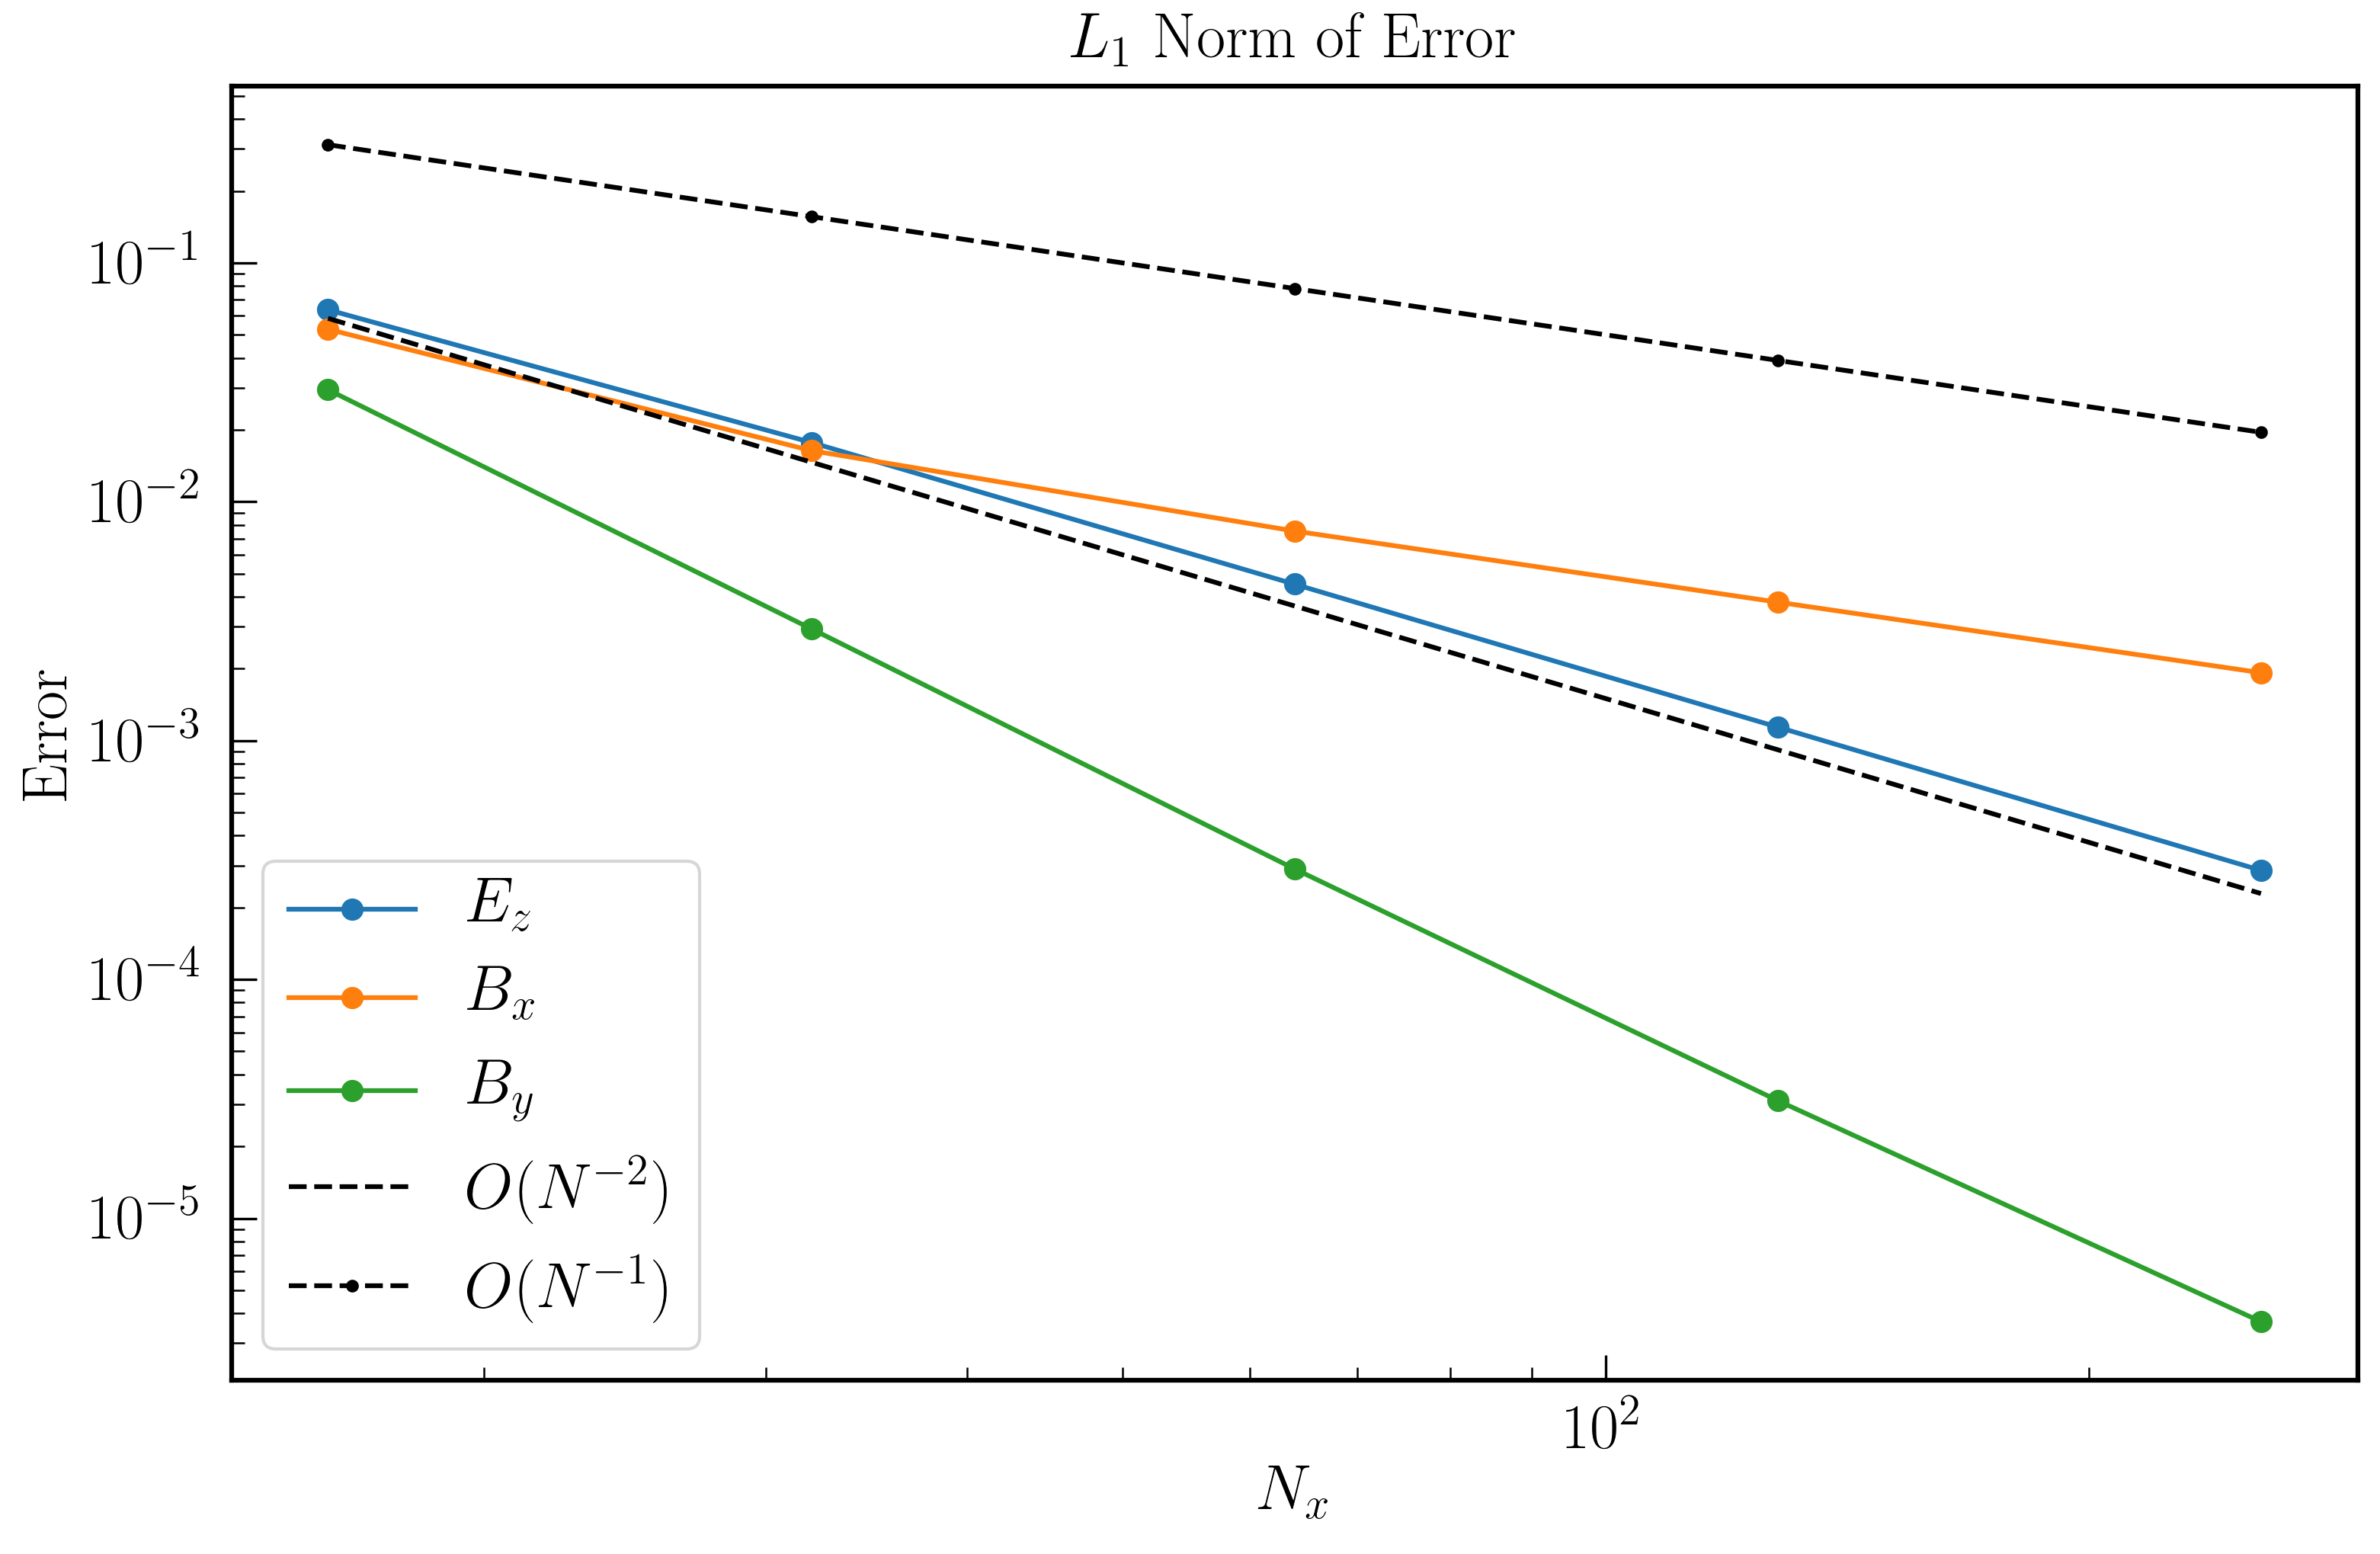

In [16]:
pl.loglog(N, error_E_z, '-o', label = '$E_z$')
pl.loglog(N, error_B_x, '-o', label = '$B_x$')
pl.loglog(N, error_B_y, '-o', label = '$B_y$')
pl.loglog(N, 15/N**2, '--', color = 'black', label = '$O(N^{-2})$')
pl.loglog(N, 5/N, '.--', color = 'black', label = '$O(N^{-1})$')
pl.legend()
pl.title('$L_1$ Norm of Error')
pl.xlabel('$N_x$')
pl.ylabel('Error')

In [17]:
pl.figure?